## Project Main Details

**Title**: Topic Modeling of IELTS Task 2 essays\
**Topic**: Natural Language Processing

## Introduction

One of the key variables of international students is the assessment of their level of English. One of the most widely known and accepted tests worldwide is the IELTS, which assesses four aspects: listening, speaking, reading, and writing. The most challenging section is the writing, specifically the second task. This task is to write an essay on a given topic (both Academic and General Training). The challenge comes because of the time pressure, task complexity, and scoring criteria. This project presents a topic modelling of the second task from the IELTS essay. The aim of this project is to cluster the essays to identify their topics and suggest to future test takers topics to practice.

# 1. Data Preprocessing with SpaCy

**Collect relevant datasets.**

The present dataset comes from the Kaggle ['IELTS Writing Scored Essays Dataset'](https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data). The first step is to load the dataset.

In [1]:
import spacy
import pandas as pd
import numpy as np
from itertools import product

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from transformers import BertTokenizer, BertModel
import torch

In [2]:
# Loading the dataset
df = pd.read_csv('ielts_writing_dataset.csv', header=0)

The next cell presents a resume of the information about the dataset. For this project, the column Essay is going to be used. In addition, the task type is going to be filtered to get only the second task.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Task_Type           1435 non-null   int64  
 1   Question            1435 non-null   object 
 2   Essay               1435 non-null   object 
 3   Examiner_Commen     62 non-null     object 
 4   Task_Response       0 non-null      float64
 5   Coherence_Cohesion  0 non-null      float64
 6   Lexical_Resource    0 non-null      float64
 7   Range_Accuracy      0 non-null      float64
 8   Overall             1435 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 101.0+ KB


In [3]:
df_filtered = df[df['Task_Type'] == 2]['Essay']
df_filtered

1       Poverty represents a worldwide crisis. It is t...
3       Human beings are facing many challenges nowada...
5       Whether countries should only invest facilitie...
7       Sports is an essential part to most of us , so...
9       International sports events require the most w...
                              ...                        
1430    Serious crimes need capital punishment so that...
1431    It is certainly said that learning is an ongoi...
1432    popular hobbies rather than their individual a...
1433    Yes, I do feel that universities should have a...
1434    The modern medicine is very important for livi...
Name: Essay, Length: 793, dtype: object

After getting the final dataset, some general preprocessing tasks are executed. After this, the dataset is ready to preprocess NLP preprocessing tasks.

In [4]:
# Removing duplicates
df_filtered_nd = df_filtered.drop_duplicates()

# Handling missing values
df_pr = df_filtered_nd.dropna()

**Preprocess the text data.**

The first step is to load the model

In [5]:
nlp = spacy.load("en_core_web_lg")

Then, it is necessary to define the function to preprocess the text with NLP methods

In [6]:
# Function to preprocess the text data
def clean_data(data):
    texts = []

    for row in data:
        # lower case the text
        lowered_row = nlp(row.lower())
        
        # remove punctuations, extra whitespace, stop words, and numbers
        tokens_processed = [token.text for token in nlp(lowered_row) if (not token.is_punct) and \
                                                                        (not token.is_space) and \
                                                                        (not token.is_stop) and \
                                                                        (not token.is_digit)]

        # remove special characters
        cleaned_tokens = [token.text for token in nlp(' '.join(tokens_processed)) if token.is_alpha]
        
        # return lemma 
        lemma_row = [token.lemma_ for token in nlp(' '.join(cleaned_tokens))]

        # append cleaned resume to the full data
        texts.append(lemma_row)
    
    return texts

It is time to preprocess with the previous defined function

In [7]:
cleaned_data = clean_data(df_pr)

## 2. Model Selection and Group Formation

### Model 1 - LDA - Model definition

LDA is the chosen model because of their assumptions: documents are mixtures of topics and that topics are mixtures of words. It is a good approach of topic modelling. It relies in three principles:
1. **Document-Topic Distribution:** The probability distribution that a specific document belongs to a multiple topics.
2. **Topic-Word Distribution:** The probability distribution of topics defined by a set of words. 
3. **Generative Process:** LDA uses a generative process to create documents. This involves:
    - Choosing a distribution of topics for each document.
    - For each word in the document, selecting a topic based on the topic distribution.
    - Generating the word from the selected topic's word distribution.

The first step is to generate a dictionary and corpus with the dataset. They are necessary to create the model. Bag of words is the word embedding method used by the library to generate the corpus.

In [22]:
# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(cleaned_data)
# create the corpus for LDA
corpus = [dictionary.doc2bow(essay) for essay in cleaned_data]

Now the dataset is splitted into training and test corpus

In [9]:
train_crp = corpus[:int(len(corpus) * 0.8)]
test_crp = corpus[int(len(corpus) * 0.8):]

### Model 2 - BERT + K-Means++

BERT was selected because of its bidirectional approach, which is suitable for language modelling and, in this case, better clustering. In addition, BERT captures the context more effectively, making the distribution of clusters more effective.\
K-Means was selected for clustering because of its simplicity but effectiveness processing. It clusters data in groups based on their similarity. It is a good approach for topic modelling tasks. The K-Means++ improved method is going to be implemented because of its refined cluster center selection based on the data. \
The first step is to generate the embeddings. Due to the nature of BERT, no preprocessing steps are involved. Thus, the raw dataset is going to be used to create the embeddings.

In [9]:
# Function to preprocess the text data for BERT
def generate_embeds_bert(data):
    # Load pre-trained model tokenizer (vocabulary)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Load pre-trained model
    model = BertModel.from_pretrained('bert-base-uncased')

    # Join data in a single line to process
    text = " ".join(data)
    # Encode text with truncation and padding
    encoded_input = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512,
                                          truncation=True, padding='max_length', return_tensors='pt')

    # Get the hidden states from the model
    with torch.no_grad():
        outputs = model(**encoded_input)

    return outputs.last_hidden_state

In [10]:
# Generate the embeddings with the raw dataset
bert_embeds = generate_embeds_bert(df_pr)

## 3. Model Training and Hyperparameter Tuning

### Model 1 - LDA - Training

First, it is necessary to know the number of topics from the dataset. To get an approximate, the number of unique questions are counted.

In [14]:
num_topics = len(list(df[df['Task_Type'] == 2]['Question'].unique()))
print(f"Number of topics (column consideration): {num_topics}")

Number of topics (column consideration): 275


The number of topics is too high. It will be considered the 10% (27-28) from this result. The building process of LDA model involves the training phase. In the following code, a function to train the model is created.

In [23]:
def train_lda_model(train_crp, dictionary, num_topics, alpha_list, eta_list,
                   passes = 10, chunksize = 10):
    # defining outputs
    model_list = []
    model_hpr_prm = {'num_topics': [], 'alpha_list' : [], 'eta_list' : []}

    # Grid search of hyperparameters  
    for num_topics in range(num_topics[0], num_topics[1], num_topics[2]):
        for alpha in alpha_list:
            for eta in eta_list:
                # Model training
                model = LdaModel(corpus=train_crp, id2word=dictionary, 
                                 passes=passes, chunksize = chunksize,
                                 num_topics=num_topics, alpha=alpha, eta=eta)
                model_list.append(model)

                # Append hyperparameters to the list to track
                model_hpr_prm['num_topics'].append(num_topics)
                model_hpr_prm['alpha_list'].append(alpha)
                model_hpr_prm['eta_list'].append(eta)

    #return model_list, coherence_values, perplexity_values, model_settings
    return model_list, model_hpr_prm

For fine-tuning, three hyperparameters are considered:
- **Number of topics:** Fundamental parameter in topic modelling. It takes the 10% of the value-based in the columns in a range of plus-minus 5 with a step of 4. 
- **Alpha:** A-priori belief on document-topic distribution. For this process, default prior strategies are selected.
- **Eta:** A-priori belief on topic-word distribution. For this process, default prior strategies are used.

In addition, other parameters are considered in the process:
- **passes:** Number of passes through the corpus during training. For this process, it is 10.
- **chunksize:** Number of documents to be used in each training chunk. For this process, it is 10.

In [12]:
# Hyperparameter definition
num_topics_smpl = int(num_topics * 0.1)
num_topics_list = [num_topics_smpl - 5, num_topics_smpl + 5, 4]
alpha_list_lda = ['symmetric','asymmetric','auto']
eta_list_lda = ['symmetric','auto']

# Training LDA model
model_list_lda, model_hpr_prm_lds = train_lda_model(train_crp=train_crp,
                                                    dictionary=dictionary,
                                                    num_topics=num_topics_list, 
                                                    alpha_list=alpha_list_lda, 
                                                    eta_list=eta_list_lda)

### Model 2 - BERT + K-Means++ - Training

For number of topics, the same consideration of LDA is considered.

In [11]:
num_topics = len(list(df[df['Task_Type'] == 2]['Question'].unique()))
print(f"Number of topics (column consideration): {num_topics}")

Number of topics (column consideration): 275


The first step is split the embeddings into training and test. 

In [12]:
train_bert = bert_embeds[0,:int(len(bert_embeds[0]) * 0.8),:]
test_bert = bert_embeds[0,int(len(bert_embeds[0]) * 0.8):,:]

The following function implements the training process for k-means++. KMeans definition has the init parameter, here only 'kmeans++' value is needed.

In [13]:
def train_kmeans_pp(data, num_topics, num_init = ['auto'], num_iter=[300], tolerance=0.0001):
    # defining outputs
    model_list = []
    inertias_list = []
    model_hpr_prm = {'n_clusters': [], 'n_init' : [], 'max_iter' : []}

    # Dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42)  # reduce to 2 components
    data_tsne = tsne.fit_transform(data.numpy())
    
    # Grid search of hyperparameters  
    for num_top in range(num_topics[0], num_topics[1], num_topics[2]):
        for num in num_init:
            for n_iter in num_iter:
                # Model training
                model = KMeans(n_clusters=num_top, n_init=num, max_iter=n_iter,
                              init='k-means++', tol=tolerance)
                model.fit(data_tsne)
                inertias_list.append(model.inertia_)
                model_list.append(model)

                # Append hyperparameters to the list to track
                model_hpr_prm['n_clusters'].append(num_top)
                model_hpr_prm['n_init'].append(num)
                model_hpr_prm['max_iter'].append(n_iter)

    return model_list, inertias_list, model_hpr_prm

For fine-tuning, there is one crucial parameter to tune first:
- **Number of topics (clusters):** Fundamental parameter in topic modelling. To select the best, the Elbow Method is used. The process is going to search for a number of clusters between 2 and the number of clusters calculated in mode 1 in steps of 2. The inertia of models is obtained for each iteration and then plotted.

In addition, other parameters are considered in the process:
- **Method for initialization (init):** For this process, k-means++ is used.
- **Tolerance:** Relative tolerance with regards to inertia to declare convergence. For this process, it is 0.0001.

In [14]:
# Hyperparameter definition
num_topics_smpl_kms = int(num_topics * 0.1)
num_topics_list_kms = [2, num_topics_smpl_kms, 2]

# Trainig of k-means models
model_list_kms, inertias_list_kms, model_hpr_prm_kms = train_kmeans_pp(data = train_bert, 
                                                                       num_topics = num_topics_list_kms)

C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_

In [15]:
# Function to generate the Elbow plot
def plot_elbow(list_k, inertias_list):
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, inertias_list, '-o')
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')

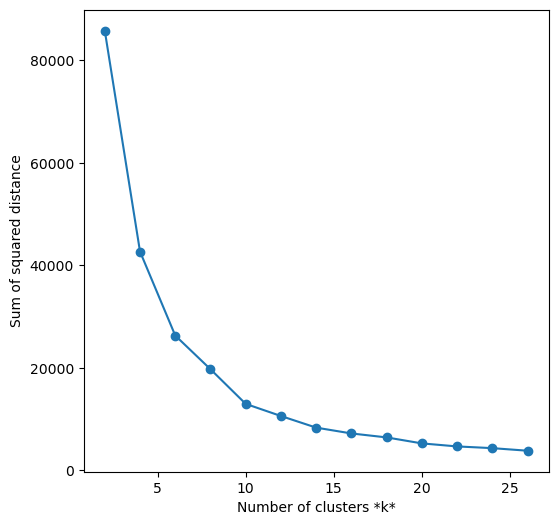

In [16]:
# Plotting the results
ranges_plot = list(range(num_topics_list_kms[0], num_topics_list_kms[1], num_topics_list_kms[2]))

plot_elbow(ranges_plot, inertias_list_kms)

The elbow bends between 4 and 6. In this case, five clusters are the number selected.

## 4. Performance Evaluation

**Evaluate the model**

To evaluate model 1, the metrics are taken considering that the model doesn't directly assign clusters to documents:
- **Perplexity:** The lower the score, the better the generalization. However, this metric can favour models with more topics. Therefore, it will be less important in the overall analysis.
- **Coherence:** The score range is between 0 and 1. Higher scores generally indicate more coherent and interpretable topics. It will have more importance in the analysis.

For model 2, which assigns clusters, different metrics are considered:
- **Silhouette score:** Score ranges are between -1 to +1, with higher values indicating better-defined clusters. 
- **Davies-Bouldin Index:** Evaluate the quality of clustering algorithms. Consider both intra-cluster similarity (compactness) and inter-cluster difference (separation). Lower values indicate better clustering quality.
- **Calinski-Harabasz Index:** It balances the compactness and separation of clusters. In other words, it indicates how well the data points are grouped into distinct clusters. Higher values indicate better balance.

To get the best model, an overall value is calculated from the three metrics for both models. This overall value is calculated using a weighted average with normalized values. The max value from these calculations is the best model.

In [17]:
# Function to evaluate the model
def evaluate_model(models, dictionary, corpus, texts):
    # defining metrics for model 1
    coherence_values = []
    perplexity_values = []
    # defining metrics for model 2
    silhouette_values = []
    db_values = []
    ch_values = []

    # Dictionary is sent only for LDA
    if dictionary is None:
        for idx in range(len(models)):
            # Calculating silhouette_values
            labels = models[idx].fit_predict(corpus)
            silhouette = silhouette_score(corpus, labels)
            silhouette_values.append(silhouette)
            # Calculating Davies-Bouldin Index
            db_score = davies_bouldin_score(corpus, labels)
            db_values.append(db_score)
            # Calculating Calinski-Harabasz Index
            ch_score = calinski_harabasz_score(corpus, labels)
            ch_values.append(ch_score)
    else:
        # Looping the models
        for idx in range(len(models)):
            # Calculating coherence
            coherence = CoherenceModel(model=models[idx], texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherence.get_coherence())
            # Calculating perplexity
            log_perplexity = models[idx].log_perplexity(corpus)
            perplexity = np.exp(log_perplexity)
            perplexity_values.append(perplexity)

    return coherence_values, perplexity_values, silhouette_values, db_values, ch_values

In [18]:
# Function to get the best model
def get_best_model(coherence_values = [], perplexity_values = [], silhouette_values = [],
                   db_values = [], ch_values = []):
    # Initializations
    model_scores = []
    scaler = MinMaxScaler()
    
    # silhouette_values are defined only for K-means
    if len(silhouette_values) > 0:
        # Weights
        weights = {'Silhouette Score': 0.4, 'Davies-Bouldin Index': 0.3, 'Calinski-Harabasz Index': 0.3}
        
        # Scores for models
        model_scores = [{'Silhouette Score': silhouette_values[i], 
                         'Davies-Bouldin Index': db_values[i],
                         'Calinski-Harabasz Index': ch_values[i]}
                         for  i in range(len(silhouette_values))]

        # Normalize scores
        normalized_scores = scaler.fit_transform([[model['Silhouette Score'], 
                                                   model['Davies-Bouldin Index'], 
                                                   model['Calinski-Harabasz Index']] 
                                                  for model in model_scores])
    else:
        # Weights
        weights = {'perplexity': 0.4, 'topic_coherence': 0.6}

        # Scores for models
        model_scores = [{'perplexity': perplexity_values_lda[i], 
                         'topic_coherence': coherence_values_lda[i]}
                         for  i in range(len(coherence_values_lda))]
    
        # Normalize scores
        normalized_scores = scaler.fit_transform([[model['perplexity'], 
                                                   model['topic_coherence']] 
                                                  for model in model_scores])
    
    # Calculate weighted normalized scores
    overall_scores = [
        sum(weights[metric] * score for metric, score in zip(weights.keys(), normalized_score))
        for normalized_score in normalized_scores
    ]

    idx_best_model = overall_scores.index(max(overall_scores))
    
    return overall_scores, idx_best_model

### Model 1 - LDA - Evaluation

The evaluation of the model is performed in two steps: first, we are going to get the model evaluation values, in this case coherence and perplexity, then, get the best score of the model with the index of the best model.

In [15]:
# Evaluate the model
coherence_values_lda, perplexity_values_lda, _, _, _ = evaluate_model(models = model_list_lda,
                                                            dictionary=dictionary, 
                                                            corpus=test_crp, 
                                                            texts=cleaned_data)
# Get the best model
scores_lda, idx_best_model_lda = get_best_model(coherence_values = coherence_values_lda, 
                                                perplexity_values = perplexity_values_lda)

In [48]:
def show_model_data(model_list, score_list, coherence_list, perplexity_list, 
                    model_hpr_prm, idx_best_model):
    best_model_lda  = model_list[idx_best_model]
    best_scr_lda = score_list[idx_best_model]
    best_coh_lda = coherence_list[idx_best_model]
    best_prp_lda = perplexity_list[idx_best_model]
    
    print("Metrics of the best model\n")
    print(f"Weighted score: {best_scr_lda:4f}")
    print(f"Coherence: {best_coh_lda:4f}")
    print(f"Perplexity: {best_prp_lda:4f}")
    print()
    print("Hyperparameters: ")
    for hyp_param in model_hpr_prm:
        print(f"{hyp_param}: {model_hpr_prm[hyp_param][idx_best_model]}")
    print("Real values: ")
    print(f'Alpha: {best_model_lda.alpha[idx_best_model]:4f}')
    print(f'Eta: {best_model_lda.eta[idx_best_model]:4f}')

In [49]:
show_model_data(model_list_lda, scores_lda, coherence_values_lda, perplexity_values_lda, 
                model_hpr_prm_lds, idx_best_model_lda)

Metrics of the best model

Weighted score: 0.922671
Coherence: 0.296677
Perplexity: 0.000000

Hyperparameters: 
num_topics: 22
alpha_list: asymmetric
eta_list: auto
Real values: 
Alpha: 0.071044
Eta: 0.046660


The metric for coherence is not good but the perplexity is perfect. Let's check the topics to analyze them.

In [38]:
def print_topics(model):
    for idx, topic in model.print_topics(-1):
        print(f"Topic #{idx}: {topic}\n")

In [40]:
print_topics(best_model_lda)

Topic #0: 0.000*"change" + 0.000*"city" + 0.000*"past" + 0.000*"time" + 0.000*"woman" + 0.000*"circumictance" + 0.000*"experinced" + 0.000*"reasonnable" + 0.000*"velvet" + 0.000*"ar"

Topic #1: 0.000*"demenssion" + 0.000*"detect" + 0.000*"littie" + 0.000*"reasonnable" + 0.000*"velvet" + 0.000*"ar" + 0.000*"circumictance" + 0.000*"glove" + 0.000*"experincee" + 0.000*"factore"

Topic #2: 0.103*"respect" + 0.049*"address" + 0.049*"currently" + 0.031*"easier" + 0.027*"variety" + 0.023*"innovation" + 0.012*"inevitably" + 0.012*"possibly" + 0.008*"classic" + 0.007*"undeniable"

Topic #3: 0.065*"country" + 0.031*"problem" + 0.024*"government" + 0.023*"environment" + 0.023*"cause" + 0.022*"use" + 0.021*"people" + 0.021*"money" + 0.020*"art" + 0.019*"company"

Topic #4: 0.000*"demenssion" + 0.000*"detect" + 0.000*"littie" + 0.000*"reasonnable" + 0.000*"velvet" + 0.000*"ar" + 0.000*"circumictance" + 0.000*"glove" + 0.000*"experincee" + 0.000*"factore"

Topic #5: 0.000*"demenssion" + 0.000*"detec

The result for coherence is not good. It is necessary to perform a second hyperparameter tuning.

### Model 1 - LDA - Second hyperparameter tuning

For this process, some changes are made to improve the model:
- **Topics:** There are some repeated topics. It is resized to half the best number of topics size as a reference. The tuning process iterates between a range of plus-minus 5 of the previously calculated number of topics. The step is 4.
- **Alpha:** Lower values can make topics more distinct. Considering the previous values, it is decreased.
- **Eta:** The same consideration of alpha is applied to this hyperparameter.
- **Number of passes:** To improve the convergence, it is increased to 30.

In [42]:
# New hyperparameter definition
num_topics_hpt_lda = int(model_hpr_prm_lds['num_topics'][idx_best_model_lda] / 2)
num_topics_hpt_list = [num_topics_hpt_lda - 5, num_topics_hpt_lda + 5, 4]
alpha_list_hpt_lda = [0.01, 0.001]
eta_list_hpt_lda = [0.01, 0.001]

# Training LDA model
model_list_hpt_lda, model_hpr_prm_lda_sec = train_lda_model(train_crp=train_crp,
                                                            dictionary=dictionary,
                                                            num_topics=num_topics_hpt_list, 
                                                            alpha_list=alpha_list_hpt_lda, 
                                                            eta_list=eta_list_hpt_lda,
                                                            passes = 30)

After training, a new evaluation is necessary to get the best model from the previous process.

In [43]:
# Evaluate the model
coherence_values_lda_hpt, perplexity_values_lda_hpt, _ = evaluate_model(models = model_list_hpt_lda,
                                                                        dictionary=dictionary, 
                                                                        corpus=test_crp, 
                                                                        texts=cleaned_data)
# Get the best model
scores_lda_hpt, idx_best_model_lda_hpt = get_best_model(coherence_values = coherence_values_lda_hpt, 
                                                        perplexity_values = perplexity_values_lda_hpt)

Finalize the evaluation, the best model is selected, and the topics are printed for checking.

In [44]:
best_model_lda_hpt  = model_list_hpt_lda[idx_best_model_lda_hpt]
print_topics(best_model_lda_hpt)

Topic #0: 0.149*"subject" + 0.143*"student" + 0.102*"study" + 0.092*"university" + 0.065*"education" + 0.058*"course" + 0.046*"teacher" + 0.034*"scientist" + 0.034*"school" + 0.032*"knowledge"

Topic #1: 0.328*"child" + 0.121*"learn" + 0.066*"teach" + 0.051*"school" + 0.047*"skill" + 0.041*"future" + 0.031*"play" + 0.031*"young" + 0.027*"understand" + 0.026*"help"

Topic #2: 0.062*"family" + 0.052*"money" + 0.052*"human" + 0.043*"help" + 0.035*"problem" + 0.029*"need" + 0.029*"solution" + 0.026*"rich" + 0.023*"solve" + 0.022*"poor"

Topic #3: 0.651*"country" + 0.243*"government" + 0.059*"citizen" + 0.026*"addition" + 0.015*"equipment" + 0.000*"experinced" + 0.000*"circumictance" + 0.000*"demenssion" + 0.000*"detect" + 0.000*"diffierent"

Topic #4: 0.057*"people" + 0.027*"believe" + 0.021*"life" + 0.017*"think" + 0.016*"history" + 0.016*"example" + 0.014*"well" + 0.014*"way" + 0.014*"good" + 0.013*"different"

Topic #5: 0.088*"people" + 0.036*"work" + 0.029*"job" + 0.029*"cause" + 0.028

A significantly less amount of topics are identified after the tuning. The full parameters of the model are shown for the analysis.

In [50]:
show_model_data(model_list_hpt_lda, scores_lda_hpt, coherence_values_lda_hpt, perplexity_values_lda_hpt, 
                model_hpr_prm_lda_sec, idx_best_model_lda_hpt)

Metrics of the best model

Weighted score: 0.922671
Coherence: 0.374241
Perplexity: 0.000000

Hyperparameters: 
num_topics: 6
alpha_list: 0.001
eta_list: 0.001
Real values: 
Alpha: 0.001000
Eta: 0.001000


The score and coherence have a small improve. However, considering that the topics presented improved in readiness and values, the model has a significant improve. It will be analyzed in the section 5.

### Model 2 - BERT + K-Means++ - Evaluation

The model with 5 clusters is trained to evaluate it. The function to evaluate models was created based on ranges. Therefore, the list of values is created to generate only one value.

In [19]:
# Trainig of k-means model with 5 clusters
num_topics_kms = [5, 6, 1]
model_list_kms, _, model_hpr_prm_kms = train_kmeans_pp(data = train_bert, 
                                                       num_topics = num_topics_kms)

# Evaluate the model
_, _, silhouette_scores_kms, db_values_kms, ch_values_kms = evaluate_model(models = model_list_kms,
                                                                            dictionary=None, 
                                                                            corpus=test_bert, 
                                                                            texts=None)

C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [20]:
def show_model_data_kms(model_list, silhouette_list, db_list, ch_list,
                       model_hpr_prm, idx_best_model):
    best_model_kms  = model_list[idx_best_model]
    best_sil_kms = silhouette_list[idx_best_model]
    best_dbi_kms = db_list[idx_best_model]
    best_chi_kms = ch_list[idx_best_model]
    
    print("Metrics of the best model\n")
    print(f"Silhouette: {best_sil_kms:4f}")
    print(f"Davies-Bouldin Index: {best_dbi_kms:4f}")
    print(f"Calinski-Harabasz Index: {best_chi_kms:4f}")
    print()
    print("Hyperparameters: ")
    for hyp_param in model_hpr_prm:
        print(f"{hyp_param}: {model_hpr_prm[hyp_param][idx_best_model]}")

In [21]:
show_model_data_kms(model_list_kms, silhouette_scores_kms, db_values_kms, ch_values_kms, 
                    model_hpr_prm_kms, 0)

Metrics of the best model

Silhouette: 0.045463
Davies-Bouldin Index: 3.384378
Calinski-Harabasz Index: 4.154607

Hyperparameters: 
n_clusters: 5
n_init: auto
max_iter: 300


The numeric results are not good. Silhouette and Calinski-Harabasz Index are low and Davies-Bouldin Index is high. Let's check the plot to visually see the results. To plot it, it is necessary to reduce the dimensionality of the dataset. TSNE is used to perform this task because the data is not linear.

In [22]:
# Function to plot the clusters of data
def plot_clusters(data, model):
    # Reducing the dimensions of the data (t-SNE)
    tsne = TSNE(n_components=2, random_state=42)  # reduce to 2 components
    X_tsne = tsne.fit_transform(data)
    # Predicting
    clusters = model.fit_predict(X_tsne)
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis')
    plt.title("Clusters visualized with t-SNE")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


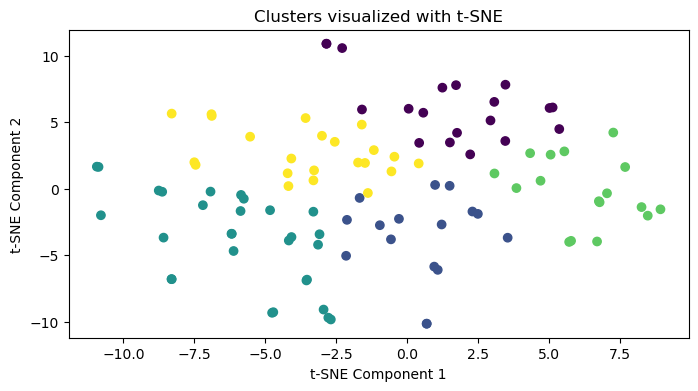

In [23]:
plot_clusters(test_bert, model_list_kms[0])

The clusters are now defined properly. The next section performs another hyperparameter tuning to check if these can be improved.

### Model 2 - BERT + K-Means++ - Second hyperparameter tuning

For this process, some changes are made to improve the model:
- **Topics:** Considering the Elbow plot, the number of topics goes from 4 to 10.
- **Centroids seeds:** Considering that 1 is the default value when kmeans++ is used and 10 when random, the new values are defined in ranges of 5 between 5 and 40.
- **Max iterations:** The first value is 300. It is increased for more runs.

In [24]:
# Hyperparameter definition
num_topics_list_kms = [4, 11, 1]
num_inits_list_kms = [5, 10, 20, 30, 40]
num_iter_list_kms = [500, 1000, 2500, 5000]

# Trainig of k-means models
model_list_kms_hpt, _, model_hpr_prm_kms_hpt = train_kmeans_pp(data = train_bert, 
                                                               num_topics = num_topics_list_kms,
                                                               num_init = num_inits_list_kms,
                                                               num_iter = num_iter_list_kms)

C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_

After training, the nest step is to get the best model and show the results of the evaluation.

In [25]:
# Evaluate the model
_, _, silhouette_scores_kms_hpt, db_values_kms_hpt, ch_values_kms_hpt = evaluate_model(models = model_list_kms_hpt,
                                                                                        dictionary=None, 
                                                                                        corpus=test_bert, 
                                                                                        texts=None)

# Get the best model
scores_kms_hpt, idx_best_model_kms_hpt = get_best_model(silhouette_values = silhouette_scores_kms_hpt,
                                                        db_values = db_values_kms_hpt, 
                                                        ch_values = ch_values_kms_hpt)

C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_

In [26]:
best_model_kms_hpt  = model_list_kms_hpt[idx_best_model_kms_hpt]

show_model_data_kms(model_list_kms_hpt, silhouette_scores_kms_hpt, db_values_kms_hpt, 
                    ch_values_kms_hpt, model_hpr_prm_kms_hpt, idx_best_model_kms_hpt)

Metrics of the best model

Silhouette: 0.067274
Davies-Bouldin Index: 3.093476
Calinski-Harabasz Index: 5.626394

Hyperparameters: 
n_clusters: 4
n_init: 40
max_iter: 2500


C:\ProgramData\anaconda3\envs\NLP1_Project2\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


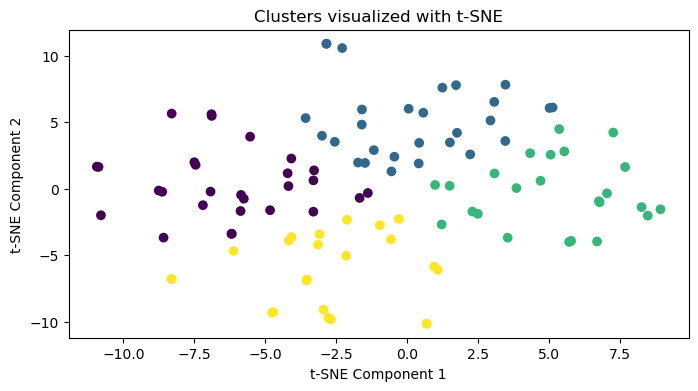

In [27]:
plot_clusters(test_bert, best_model_kms_hpt)

## 5. Analysis and Conclusion

**Analyze the results obtained from various models and hyperparameter configurations.**

The clustering topic modelling tasks have one crucial parameter that must be tuned first: the number of topics. Calculating this value is not an easy task at present. The essay writing IELTS task is the result of writing an essay about a point of view, problem, or argument. These are a set of instructions given in the form of a short paragraph with some details about how to structure the essay. Considering this problem, getting unique instructions from the dataset is a fair approach to getting an initial number of topics. However, even considering this approach, a high number of topics were calculated. It was reduced to 10% to get better results. In addition, a range of topics was considered, with values coming around the number of topics as the center value.\
For model 1, a range of topics and default prior values are considered to benchmark the model. Grid search was used as a hyperparameter tuning process. The first tuning process results in a perfect perplexity score but low coherence (0.29) and many topics. Regarding coherence, the essays were not filtered by score result, and the scores were between B and C levels. Thus, grammar and writing must be consistent, which makes perplexity value sense. However, consistency is an aspect that is evaluated when scoring these essays; therefore, many essays do not have that consistency in writing. Regarding the number of topics, the result was less valuable in the topic defined range. Thus, it is necessary to reduce it. After the second tuning process, coherence improved to 0.37, possibly due to the refinement added by C-level essays not considered in the first tuning and the reduced number of topics to less than 10.\
For model 2, the same initial hyperparameter considerations were applied to perform the first training and tuning. However, two elements were added: the Elbow Method for topic analysis and BERT implementation. The results of the elbow method supported the previous number of topics used; thus, regarding the wide number of instructions, they can be reduced to a low number of topics. The model was trained and used the same number of topics for the topic, but the results were not good. After the second tuning process, the silhouette score fairly improved, and the Davies-Bouldin and Calinski-Harabasz Index remained almost the same. The cluster plot is similar to the model 1, therefore, we can get similar conclusions as the previous model.

**Discuss the impact of SpaCy in comparison to other models in terms of performance and computational efficiency.**

In this project, SpaCy and sklearn models have consistent results according to the clusters. The coherence is the lower value but the clusters present a consistent result. For k-means, the indexes are not that good values, but similar to SpaCy; the clusters are well-conformed according to the problem. In terms of computational efficiency, SpaCy model is slower than k-means. Using several hyperparameters, the k-means model did not take too much time to tune in comparison to k-means.

**Draw conclusions on the suitability of different models and hyperparameter settings for the given dataset and task.**

The limitation of the LDA model is that it uses a Bag of Words to vectorize the dataset. Despite the fact that LDA is a powerful method for performing topic modelling, the vector does not give the context that can improve the results of the process. The hyperparameters did not take a wide range of values because the essays refer to a limited number of topics. Thus, extra lower or higher values are not necessary to tune the model.
The use of BERT gives a powerful context process to get the proper vector to cluster. In this case, k-means++ was used because of its simplicity and power. It is possible to implement more powerful models to compare their performance and verify if the complexity addition is necessary. 

## References

- Barragan, A. C. (2024, July 16). Interpreting and validating clustering results with K-means. Medium. https://medium.com/@a.cervantes2012/interpreting-and-validating-clustering-results-with-k-means-e98227183a4d
- GeeksforGeeks. (2025, February 4). Difference between agglomerative clustering and divisive clustering. https://www.geeksforgeeks.org/difference-between-agglomerative-clustering-and-divisive-clustering/ 
- Ibrahimmazlum. (2023, July 20). Ielts writing scored essays dataset. Kaggle. https://www.kaggle.com/datasets/mazlumi/ielts-writing-scored-essays-dataset/data
- Khalid, S. (2020, April 10). Bert explained: A Complete Guide with Theory and tutorial. Medium. https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c 
- St Clair, D. (2011, October 9). Ielts preparation writing task 1. SlideServe. https://www.slideserve.com/Audrey/cambridge-esol-examinations 